In [ ]:
# we are using stellergraph and this implementation follows their example: 
# https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html

In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [8]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


In [10]:
print(G_train.info())
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4399

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4399]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4887

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4887]
        Weights: all 1 (default)
        Features: none


In [11]:
batch_size = 20
epochs = 50
num_samples = [20, 10] # 1hop, 2hop samples

In [12]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [13]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [14]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [15]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

In [16]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

c:\ProgramData\Miniconda3\envs\gcn\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
# evaluate untrained
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

55/55 [==============================] - 5s 85ms/step - loss: 0.8323 - acc: 0.6513

Train Set Metrics of the initial (untrained) model:
	loss: 0.8475
	acc: 0.6660

Test Set Metrics of the initial (untrained) model:
	loss: 0.8323
	acc: 0.6513


In [19]:
# train the model 
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/50
49/49 - 12s - loss: 0.7403 - acc: 0.5994 - val_loss: 0.6258 - val_acc: 0.6338 - 12s/epoch - 236ms/step
Epoch 2/50
49/49 - 9s - loss: 0.5325 - acc: 0.7336 - val_loss: 0.5044 - val_acc: 0.7509 - 9s/epoch - 187ms/step
Epoch 3/50
49/49 - 10s - loss: 0.4218 - acc: 0.8289 - val_loss: 0.4759 - val_acc: 0.7731 - 10s/epoch - 210ms/step
Epoch 4/50
49/49 - 10s - loss: 0.3472 - acc: 0.8791 - val_loss: 0.4618 - val_acc: 0.8164 - 10s/epoch - 201ms/step
Epoch 5/50
49/49 - 9s - loss: 0.2973 - acc: 0.8986 - val_loss: 0.4513 - val_acc: 0.8173 - 9s/epoch - 184ms/step
Epoch 6/50
49/49 - 11s - loss: 0.2698 - acc: 0.9191 - val_loss: 0.4739 - val_acc: 0.8127 - 11s/epoch - 217ms/step
Epoch 7/50
49/49 - 10s - loss: 0.2408 - acc: 0.9436 - val_loss: 0.4865 - val_acc: 0.8137 - 10s/epoch - 203ms/step
Epoch 8/50
49/49 - 9s - loss: 0.2184 - acc: 0.9518 - val_loss: 0.4967 - val_acc: 0.8220 - 9s/epoch - 189ms/step
Epoch 9/50
49/49 - 11s - loss: 0.1900 - acc: 0.9693 - val_loss: 0.4585 - val_acc: 0.8173 - 11s

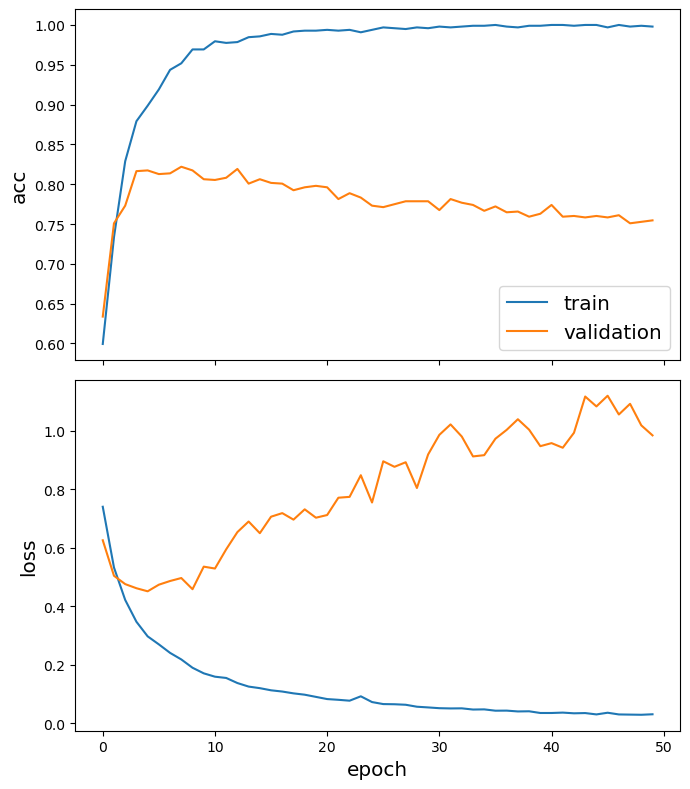

In [21]:
sg.utils.plot_history(history)

In [22]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

55/55 [==============================] - 4s 78ms/step - loss: 1.0186 - acc: 0.7500

Train Set Metrics of the trained model:
	loss: 0.0187
	acc: 1.0000

Test Set Metrics of the trained model:
	loss: 1.0186
	acc: 0.7500
